# COMPUTING INFORMATION-THEORETIC METRICS — BINNING/HISTOGRAM APPROACH

This python script computes four information-theoretic metrics based on given EEG neural timeseries data, specifically for hyperscanning (part of the HyPyP pipeline):
- Shannon Entropy (Univariate and Bivariate)
- Mutual Information
- Symmetric Uncertainty
- Transfer Entropy
- Granger Emergence

Each of these will be explained in turn, with respective mathematical equations. This serves as an introduction to probability as well as the first mode of computing these measures: the binning or histogram approach. (It should be noted that whilst this is computationally inexpensive, it is not as robust as other metrics.) For full derivations, see Appendix.

## CONTENTS


- 1. [Import Libraries](#1.-IMPORT-LIBRARIES)
- 2. [Load Data](#2.-LOAD-DATA)
- 3. [Shannon Entropy](#3.-SHANNON-ENTROPY) 
   - 3.1. [Freedman-Diaconis Rule for determining frequency-distribution bin size](#3.1-Freedman-Diaconis-Rule-for-determining-frequency-distribution-bin-size)
   - 3.2. [Frequency Distribution](#3.2-Frequency-Distribution)
   - 3.3. [Probability Mass Distribution](#3.3-Probability-Mass-Distributions)
   - 3.4. [Compute Shannon Entropy](#3.4-Compute-Shannon-Entropy)
   - 3.5. [Joint & Marginal Distributions](#3.5-Joint-&-Marginal-Distributions)
   - 3.6. [Joint Probability Mass Distribution](#3.6-Joint-Probability-Mass-Distribution)
   - 3.7. [Calculating Joint Entropy](#3.7-Calculating-Joint-Entropy)
- 4. [Mutual Information](#4.-MUTUAL-INFORMATION)
- 5. [Symmetric Uncertainty](#5.-SYMMETRIC-UNCERTAINTY)



# 1. Import Libraries

## Core

In [1]:
import io
from pathlib import Path
from copy import copy
from collections import OrderedDict

## Data Science

In [2]:
import numpy as np
import scipy
from scipy import stats
from scipy.integrate import odeint

## Visualisation

In [3]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
from mpl_toolkits.axes_grid1 import make_axes_locatable

from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

## MNE

In [4]:
import mne
from mne.channels import make_standard_montage
from mne.viz import plot_topomap

# 2. LOAD DATA

Sample EEG data in fiff format: 
- /data/participant1-epo.fif
- /data/participant2-epo.fif

Can be found online: "https://github.com/ppsp-team/HyPyP/blob/master/data/.."

In [5]:
epo1 = mne.read_epochs(
    Path('data/participant1-epo.fif').resolve(),
    preload=True,
)

epo2 = mne.read_epochs(
    Path('data/participant2-epo.fif').resolve(),
    preload=True,
)

Reading /Users/edoardochidichimo/Desktop/HyPyP/data/participant1-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/edoardochidichimo/Desktop/HyPyP/data/participant2-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Ensure that there are the same number of epochs between the participants' data.

In [6]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

First, we must extract the data from each epoch and store the tensor of raw data as variables ```a,b```. (Notice that these will take 3 dimensions: an array of channels, an array of epochs, an array of amplitude values (µV) with each value representing one timepoint.)

Although currently default, we set ```copy=False``` as FutureWarning indicates that this function will set to change default. Since we are not changing the data, we do not need to make a copy.

In [7]:
a = epo1.get_data(copy=False)
b = epo2.get_data(copy=False)

We can also decide which channel or epoch we want to work with, so let us set local variables. Later, we might choose to repeat our analyses across all epochs (trial-averaged). There are 36 epochs and 31 channels per participant in total. 

For demonstration purposes, let us just take the first epoch of the first channel for both participants. In this way, variables ```X,Y``` become an array of 501 µV values. (This suggests that there are 501ms timestamps (= 5 seconds).)

In [8]:
n_epo, n_ch, n_samples = a.shape

#For now let's only look at the first epoch of the first channel
n_epo = 0
n_ch = 0

X = a[n_epo][n_ch][:]
Y = b[n_epo][n_ch][:]

Let's visualise what these EEG signals look like...

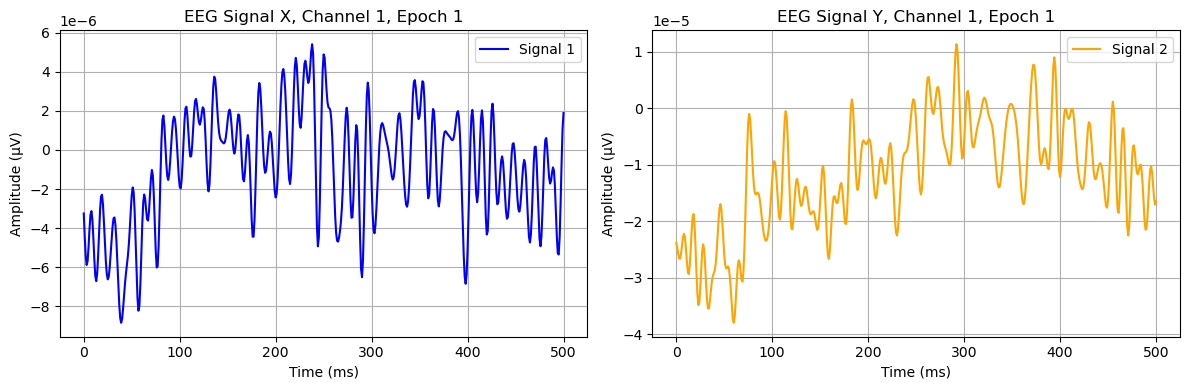

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(X, label='Signal 1', color='blue')
plt.title(f'EEG Signal X, Channel {n_ch+1}, Epoch {n_epo+1}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(Y, label='Signal 2', color='orange')
plt.title(f'EEG Signal Y, Channel {n_ch+1}, Epoch {n_epo+1}')    
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. SHANNON ENTROPY

Recall that the Shannon information content of a sample ```x``` (whose value is a probability) is given by the equation

$\begin{equation}
h(x) = -log_2(p_X(x))
\end{equation}$

where $x$ is an outcome of random variable $X$ with probability distribution $p_X(x)$. In this context, if we wanted to find the information content of a sample where $x = P(X = 2$μV$)$, one would first count all the times in the signal 2μV appeared ($f$) and divide it by the total samples ($|\Omega|$ or ```n_samples```):

$x = P(X = 2\text{μV}) = \frac{f}{|\Omega|}$

In [10]:
f = sum(1 for i in range(n_samples) if a[n_ch][n_epo][i] == 2e-6)
print(f)

0


Here, this seems to indicate that the EEG signal never passes through 2μV, even though our initial graph clearly indicates that a voltage of 2μV was recorded multiple times. However, given we have a discrete, non-infinite dataset with a sampling rate on the ms scale and high-precision floating-point numbers, it is very unlikely that any value of μV will repeat. Indeed, let's look at the first 10 amplitude values:

In [11]:
print(a[0][0][0:10])

[-3.25229999e-06 -4.42781136e-06 -5.42218048e-06 -5.88558514e-06
 -5.68590048e-06 -4.95354369e-06 -4.02638222e-06 -3.31316374e-06
 -3.12900816e-06 -3.57706454e-06]


In these cases, we will always result in a tiny $f$ value. This becomes clearer if we are to find the probability for every value with 16-bit accuracy ($P(X = 2.3782083)$ or $P(X = -3.4009829)$ etc.). 

A more meaningful approach would be to group the voltage values into equally-sized bins (e.g., -5 – -2μV; -2 – 1μV; 1 – 4μV) and calculate the frequency of voltage values in each bin. In this way, the possible samples ($|\Omega|$) become much more defined and frequencies become more meaningful.

But isn't the choice of bin size an arbitrary one? Indeed, it is, and it can greatly influence your resulting entropy values. Therefore, we use ...

## 3.1 Freedman-Diaconis Rule for determining frequency-distribution bin size

$\begin{equation}
\text{nbins} = \left\lceil \frac{\text{max}(X)-\text{min}(X)}{2Q_X n^{-1/3}} \right\rceil
\end{equation}$ 

where max($X$) and min($X$) signify the maximum and minimum values of variable $X$, respectively, $Q_X$ represents the interquartile range of $X$, and $n$ is the total number of data points (```n_samples```). To save repetition, let's compute these frequency distribution bins for *both* signals $X$ and $Y$. (Note that we can find the range by using ```np.ptp()```.) 

Later, when we compute joint probabilities, we will need to have a standardised frequency distribution bin size for both signals. Therefore, we take the average of both now.

In [12]:
fd_bins_X = np.ceil(np.ptp(X) / (2.0 * stats.iqr(X) * len(X)**(-1/3)))
fd_bins_Y = np.ceil(np.ptp(Y) / (2.0 * stats.iqr(Y) * len(Y)**(-1/3)))
fd_bins = int(np.ceil((fd_bins_X+fd_bins_Y)/2))
print(fd_bins)

15


## 3.2 Frequency Distribution

Now let's go figure out what these bin ranges are for each variable. It is very likely they will not be the same for both. Look at EEG signal1 and signal2 again; notice how the first signal almost reaches -9μV whilst the lowest for the other doesn't even reach -4μV. Their ranges are different and, whilst we want to maintain the same number of bins, the actual ranges will differ. Let's find out these bin ranges and their so-called **edges**. But, remember that whilst we may have 15 bins, we need 16 bin edges (to account for the very first or very last, depending how you look at it, boundary).

In [13]:
n_bin_edges = fd_bins+1

edges_X = np.linspace(min(X), max(X), n_bin_edges)
edges_Y = np.linspace(min(Y), max(Y), n_bin_edges)
print('X edges:',edges_X)
print('Y edges:',edges_Y)

X edges: [-8.84285850e-06 -7.89307453e-06 -6.94329056e-06 -5.99350658e-06
 -5.04372261e-06 -4.09393864e-06 -3.14415466e-06 -2.19437069e-06
 -1.24458672e-06 -2.94802744e-07  6.54981229e-07  1.60476520e-06
  2.55454918e-06  3.50433315e-06  4.45411712e-06  5.40390109e-06]
Y edges: [-3.80025891e-05 -3.47129178e-05 -3.14232464e-05 -2.81335751e-05
 -2.48439037e-05 -2.15542324e-05 -1.82645611e-05 -1.49748897e-05
 -1.16852184e-05 -8.39554703e-06 -5.10587568e-06 -1.81620434e-06
  1.47346700e-06  4.76313835e-06  8.05280969e-06  1.13424810e-05]


Now, let's go through each value in our signal and assign which bin they should be in. We will be left with an array of length 501, where each value is a number between 1–```fd_bins```, indicating which bin that particular value should be in. We can use ```np.digitize``` to do this.

In [14]:
X_which_bin = np.digitize(X, edges_X, right=False)
Y_which_bin = np.digitize(Y, edges_Y, right=False)
#Let's see just the first ten values of each
print('X:',X_which_bin[0:10])
print('Y:',Y_which_bin[0:10])

X: [6 5 4 4 4 5 6 6 7 6]
Y: [5 5 4 4 4 4 5 5 5 5]


We can add up the amount of times bin1, bin2, ..., bin(```fd_bins```) occurs in each signal and produce an array that gives us this **frequency distribution**.```np.unique``` can do this for us: it returns all unique values (```np.unique(...)[0] = [1,2,3,4,5,6,...,16]```) and their frequency (```np.unique(..., return_counts=True)[1] = [f of bin1, f of bin2, ..., f of bin16]```).

In [15]:
_, counts_X = np.unique(X_which_bin, return_counts=True, axis=0)
_, counts_Y = np.unique(Y_which_bin, return_counts=True, axis=0)
print(counts_X)
print(counts_Y)

[ 7  2 18 18 31 36 48 56 56 66 63 53 23 17  6  1]
[ 7  8 19 21 23 42 53 65 73 60 43 52 21 10  3  1]


## 3.3 Probability Mass Distributions
Normalise the frequencies to obtain an array of probabilities (a "probability distribution") that an amp value will land in that bin. Since we are working with discretised data, we call this the probability *mass* distribution, as opposed to *density* for continuous data.

$\begin{equation}
p_X = [ P(X=\text{bin 1}), P(X=\text{bin 2}), ..., P(X=\text{bin fd_bins}) ]
\end{equation}$

Very simply, to calculate the **probability (mass) distribution**, we  normalise each value: divide them by the total of each respective array. Since we know there were ```n_samples``` in our original array, we know that all the values add up to this.

In [16]:
pmd_X = counts_X.astype(float) / n_samples
pmd_Y = counts_Y.astype(float) / n_samples
print('Probability mass distribution of X:',pmd_X)
print('Probability mass distribution of Y:',pmd_Y)

Probability mass distribution of X: [0.01397206 0.00399202 0.03592814 0.03592814 0.06187625 0.07185629
 0.09580838 0.11177645 0.11177645 0.13173653 0.1257485  0.10578842
 0.04590818 0.03393214 0.01197605 0.00199601]
Probability mass distribution of Y: [0.01397206 0.01596806 0.03792415 0.04191617 0.04590818 0.08383234
 0.10578842 0.12974052 0.14570858 0.11976048 0.08582834 0.10379242
 0.04191617 0.01996008 0.00598802 0.00199601]


We can visualise their normalised frequency distributions or probability mass distributions:

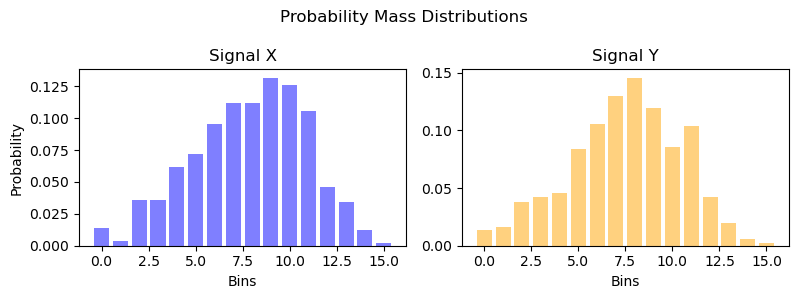

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    
axs[0].bar(np.arange(n_bin_edges), pmd_X, alpha=0.5, color='blue', label='Signal X')
axs[0].set_title('Signal X')
axs[0].set_xlabel('Bins')
axs[0].set_ylabel('Probability')

axs[1].bar(np.arange(n_bin_edges), pmd_Y, alpha=0.5, color='orange', label='Signal Y')
axs[1].set_title('Signal Y')
axs[1].set_xlabel('Bins')

plt.suptitle('Probability Mass Distributions')
plt.tight_layout()
plt.show()

## 3.4 Compute Shannon Entropy

Now that we have our probability distributions of both our signals, we can calculate the Shannon entropy for each signal.

Recall, that Shannon entropy is given by

\begin{equation}
H(X) = -\sum_{x \in \mathcal{X}} P_X(x) \log_2(P_X(x))
\end{equation}

We are going to compute $H(X)$, $H(Y)$, and $H(X,Y)$, therefore we will instantiate a Shannon entropy array, ```S_entropy``` with three spaces.

In [18]:
S_entropy = np.zeros(3)
S_entropy[0] = -np.sum(pmd_X * np.log2(pmd_X + np.finfo(float).eps))
S_entropy[1] = -np.sum(pmd_Y * np.log2(pmd_Y + np.finfo(float).eps))

print('Shannon entropies: \nH(X) =',S_entropy[0],'\nH(Y) =',S_entropy[1])

Shannon entropies: 
H(X) = 3.5832673502207397 
H(Y) = 3.562699858200045


We are ready to define our first function ```entropy_hist(X, Y)``` which will, given two np.arrays, compute the average Shannon **entropy** of each signal (using the binning/**hist**ogram approach). We will calculate the average entropy for each epoch (as we did above for the first epoch) and then average each of these for each electrode channel. The function will then return an array of entropy values for each electrode channel, for each signal.

In [19]:
def entropy_hist(a: np.array, b: np.array):

    assert a.shape == b.shape, "Both signals must have the same shape"
    
    n_epo = a.shape[0]
    n_ch = a.shape[1]
    n_samples = a.shape[2]
    
    avg_ch_entropies = []
    
    for ch_i in range(n_ch):
        
        avg_ch_entropies_X = 0
        avg_ch_entropies_Y = 0
        
        for epo_j in range(n_epo):
        
            Xi = a[epo_j][ch_i][:] #array of amp values for that epoch and channel
            Yi = b[epo_j][ch_i][:]
        
            fd_bins_X = np.ceil(np.ptp(Xi) / (2.0 * stats.iqr(Xi) * len(Xi)**(-1/3)))
            fd_bins_Y = np.ceil(np.ptp(Yi) / (2.0 * stats.iqr(Yi) * len(Yi)**(-1/3)))
            fd_bins = int(np.ceil((fd_bins_X+fd_bins_Y)/2))
    
            
            n_bin_edges = fd_bins+1 # Include last edge as a bin, too
            edges_X = np.linspace(min(Xi),max(Xi), n_bin_edges)
            X_which_bin = np.digitize(Xi, edges_X, right=False)
            edges_Y = np.linspace(min(Yi),max(Yi), n_bin_edges)
            Y_which_bin = np.digitize(Yi, edges_Y, right=False)
    
            _, counts_X = np.unique(X_which_bin, return_counts=True, axis=0)
            _, counts_Y = np.unique(Y_which_bin, return_counts=True, axis=0)
    
            pmd_X = counts_X.astype(float) / n_samples
            pmd_Y = counts_Y.astype(float) / n_samples
    
            avg_ch_entropies_X += -np.sum(pmd_X * np.log2(pmd_X + np.finfo(float).eps))
            avg_ch_entropies_Y += -np.sum(pmd_Y * np.log2(pmd_Y + np.finfo(float).eps))
            
        avg_ch_entropies_X /= n_epo
        avg_ch_entropies_Y /= n_epo
        
        avg_ch_entropies.append([avg_ch_entropies_X, avg_ch_entropies_Y])
    
    return np.array(avg_ch_entropies)

In [20]:
a = epo1.get_data(copy=False)
b = epo2.get_data(copy=False)

avg_ch_entropies = entropy_hist(a,b)
#print(avg_ch_entropies)

Now, let's visualise this using topomaps!

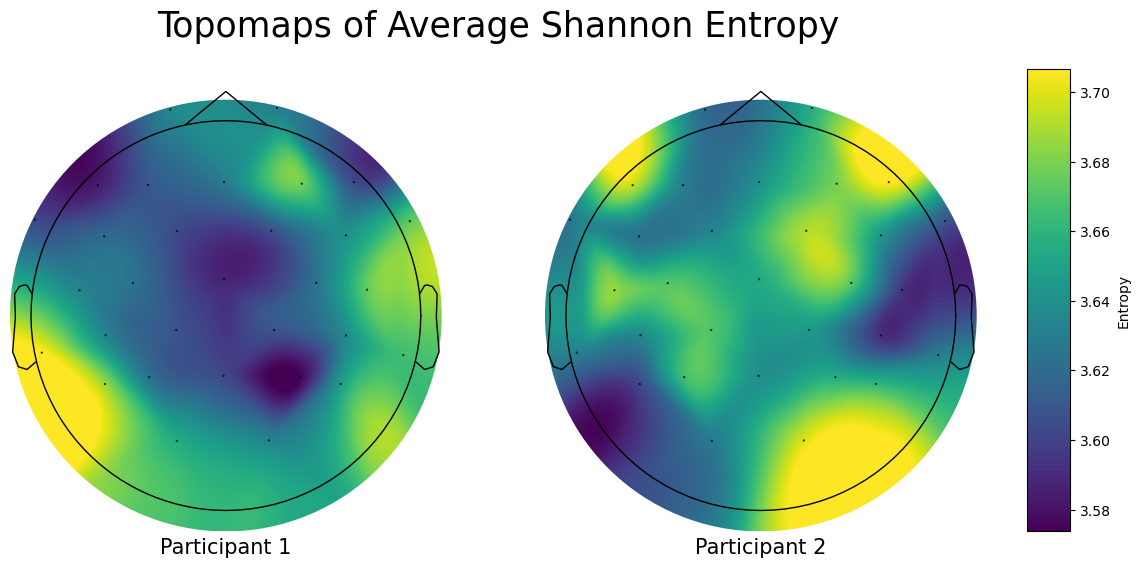

In [21]:
results = entropy_hist(a,b)
pp1, pp2 = results[:, 0], results[:, 1]

montage = make_standard_montage('standard_1020')
info1 = mne.create_info(epo1.info.ch_names, sfreq=1, ch_types='eeg').set_montage(montage)
info2 = mne.create_info(epo2.info.ch_names, sfreq=1, ch_types='eeg').set_montage(montage)

# Create an Evoked object with average entropy values
evoked1 = mne.EvokedArray(pp1[:, np.newaxis], info1)
evoked2 = mne.EvokedArray(pp2[:, np.newaxis], info2)


fig, axes = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=.001)

img1,_ = mne.viz.plot_topomap(results[:,0], evoked1.info, ch_type = 'eeg', cmap='viridis',
                     vlim=[np.min(results), np.max(results)], show=False, sensors=True, contours=0, axes=axes[0])
axes[0].set_xlabel('Participant 1', fontsize=15)

img2,_ = mne.viz.plot_topomap(results[:,1], evoked2.info, ch_type = 'eeg', cmap='viridis',
                     vlim=[np.min(results), np.max(results)], show=False, sensors=True, contours=0, axes=axes[1])
axes[1].set_xlabel('Participant 2', fontsize=15)

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='10%', pad=.5)
cbar = plt.colorbar(img2, cax=cax, orientation='vertical')
cbar.set_label('Entropy')

plt.suptitle('Topomaps of Average Shannon Entropy', fontsize=25)
plt.show()

## 3.5 Joint & Marginal Distributions

To calculate our joint entropy $H(X,Y)$ (recall this will be our ```S_entropy[2]```),
we first need to calculate the joint probability, $p_{XY}(x,y)$, which assumes that both random variables $X$ and $Y$ are defined on the same outcome space. This, in turn, is given by

$\begin{equation}
p_{X,Y}(x,y) = \mathrm{P}(X=x) \cdot \mathrm{P}(Y=y \mid X=x) = \mathrm{P}(Y=y) \cdot \mathrm{P}(X=x \mid Y=y) 
\end{equation}$

This symmetrical identity is often referred to as the "chain rule" or "product rule" of probability.

Visualising the **joint distribution** of the signals as a scatterplot with each of the signals' "marginal probabilities" (i.e., individual distributions, denoted as histograms on each side) can afford us a better intuitive about their co-distributions. Note, that this **not** a joint *probability* space; instead, each point in the scatter plot represents a pair of corresponding values from signals X and Y, such that the *i*th point has the coordinates ```X[i],Y[i]``` 

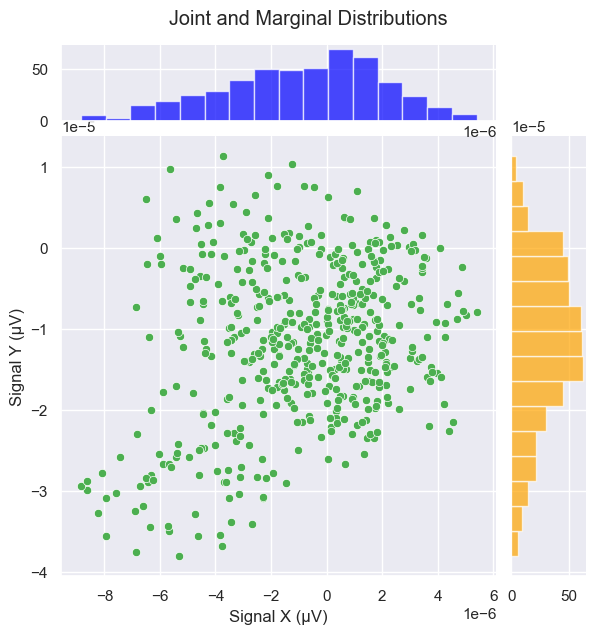

In [22]:
sns.set()
grid = sns.JointGrid(x=X, y=Y, marginal_ticks=True)
grid.plot_joint(sns.scatterplot, color='#4CAF50')
grid.ax_marg_x.hist(X, bins=n_bin_edges, color='blue', alpha=0.7)
grid.ax_marg_y.hist(Y, bins=n_bin_edges, color='orange', alpha=0.7, orientation='horizontal')

grid.set_axis_labels('Signal X (μV)', 'Signal Y (μV)')
grid.fig.suptitle('Joint and Marginal Distributions', y=1.02)
plt.show()

## 3.6 Joint Probability Mass Distribution


Now that we have our bin indices for each variable, let's see which values are in that bin by creating an array of 1s and 0s, indicating whether it is in the bin or not, respectively. For example, if we want to know which values of ```X``` are in the first bin, represented as 

``` 
X_which_bin = [1 2 1 3 3 7 1 ... ]
  X_in_bin1 = [1 0 1 0 0 0 1 ... ]
```

we can compute this as: 

In [23]:
X_in_bin1 = (X_which_bin == 1).astype(int)
Y_in_bin1 = (Y_which_bin == 1).astype(int)

Finally, we can do this for both variables, for every combination of bins. The summation of co-occuring incidences of specific bin indices, divided by the total frequency will give us their joint probability distribution. 

But first, to demonstrate, we want to know when both variables are in the first bin

```
X_in_bin1 = [1 0 1 0 0 0 1 ...]
Y_in_bin1 = [0 1 1 0 0 0 1 ...]

```

We can then recognise that their "marginal" (individual) probabilities for that particular bin might both be ```3/n_samples```, for example. However, their joint probability is the fraction of times they **co-occur**:

```
XY_in_bin1 = [0 0 1 0 0 0 1 ...]
```
which may only be  ```2/n_samples```. Notice how we are not assuming independence of both variables since the joint probability could easily be equated as $ p_XY(x,y) = \mathrm{P}(X=x) \cdot \mathrm{P}(Y=y)$ rather than $ p_XY(x,y) = \mathrm{P}(X=x) \cdot \mathrm{P}(Y=y \mid X=x)$. We can compute this:

In [24]:
XY_in_bin1 = np.logical_and(X_in_bin1, Y_in_bin1).astype(int)
print(np.sum(XY_in_bin1))


1


Therefore, we can make a large matrix that stores how many times ```x``` and ```y``` **co-occur** in any combination of bins (in other words, share the same specified bin indices), such that the shape of the matrix will be

```
[[X_in_bin1 AND Y_in_bin1, X_in_bin1 AND Y_in_bin2, X_in_bin1 AND Y_in_bin3, ..., X_in_bin1 AND Y_in_binN],
 [X_in_bin2 AND Y_in_bin1, X_in_bin2 AND Y_in_bin2, X_in_bin2 AND Y_in_bin3, ..., X_in_bin2 AND Y_in_binN],
 [X_in_bin3 AND Y_in_bin1, X_in_bin3 AND Y_in_bin2, X_in_bin3 AND Y_in_bin3, ..., X_in_bin2 AND Y_in_binN],
                                             
                                             ....
                                             ....
                                             ....
                                             
 [X_in_binN AND Y_in_bin1, X_in_binN AND Y_in_bin2, X_in_binN AND Y_in_bin3 ..., X_in_binN AND Y_in_binN]]
```

We can then normalise this large matrix by dividing every value by the summation of frequencies in the matrix. This, as it did for frequency distribution $\rightarrow$ probability mass distribution, will transform the joint frequency distribution $\rightarrow$ joint probability mass distribution.

In [25]:
# Recall:   X_which_bin = np.digitize(X, edges, right=False)
#          Y_which_bin = np.digitize(Y, edges, right=False)

joint_freq = np.zeros((n_bin_edges,n_bin_edges))
joint_probs = np.zeros((n_bin_edges,n_bin_edges))
X_in_bin = np.zeros(n_samples)
Y_in_bin = np.zeros(n_samples)

for i in range(n_bin_edges):
    
    #Initialise an array of 1s and 0s indicating whether sample x is in bin i
    X_in_bin = (X_which_bin == i+1).astype(int)
    
    for j in range(n_bin_edges):
        
        # Initialise the same for y
        Y_in_bin = (Y_which_bin == j+1).astype(int)
        
        # Create an array of x_in_bin AND y_in_bin
        XY_in_bin = np.logical_and(X_in_bin, Y_in_bin).astype(int)
        
        # Summate the co-occurences
        tot_joint = np.sum(XY_in_bin)
        joint_freq[i,j] = tot_joint

print('Joint frequency distribution:\n',joint_freq)

#Normalise to obtain (joint) probability distribution
joint_probs /= np.sum(joint_freq)

Joint frequency distribution:
 [[ 1.  1.  4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  3.  4.  2.  1.  1.  0.  0.  1.  1.  1.  2.  0.  1.  0.  0.]
 [ 2.  1.  0.  5.  1.  0.  2.  1.  2.  0.  2.  0.  1.  0.  1.  0.]
 [ 1.  1.  0.  3.  3.  2.  1.  3.  2.  3.  5.  3.  3.  1.  0.  0.]
 [ 2.  1.  3.  2.  4.  3.  0.  1.  5.  6.  2.  3.  1.  2.  0.  1.]
 [ 0.  1.  5.  2.  3.  3.  3.  8.  4.  4.  5.  6.  3.  1.  0.  0.]
 [ 0.  0.  2.  1.  0.  4. 12.  7. 11.  7.  2.  4.  3.  1.  2.  0.]
 [ 0.  0.  0.  1.  0.  5. 10. 11. 12.  5.  3.  5.  2.  2.  0.  0.]
 [ 0.  0.  0.  1.  3.  9.  7.  9. 10. 11.  5.  7.  3.  1.  0.  0.]
 [ 0.  0.  0.  2.  4.  7.  6.  7. 12. 12.  6.  5.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  2.  5.  6. 11.  8.  3.  6. 10.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  6.  1.  3.  5.  4.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  1.  5.  1.  4.  1.  0.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  

Let's clean this up... (to save creating the redundant variable ```joint_freq``` which we will not use later, let's use ```joint_probs```)

In [26]:
joint_probs = np.zeros((n_bin_edges,n_bin_edges))
for i in range(n_bin_edges):
    for j in range(n_bin_edges):
        joint_probs[i,j] = np.sum(np.logical_and((X_which_bin == i+1).astype(int), (Y_which_bin == j+1).astype(int)).astype(int))

joint_probs /= np.sum(joint_probs)

Let's visualise this joint probability spaces $p_{XY}(X,Y)$ using 2D and 3D heatmaps:

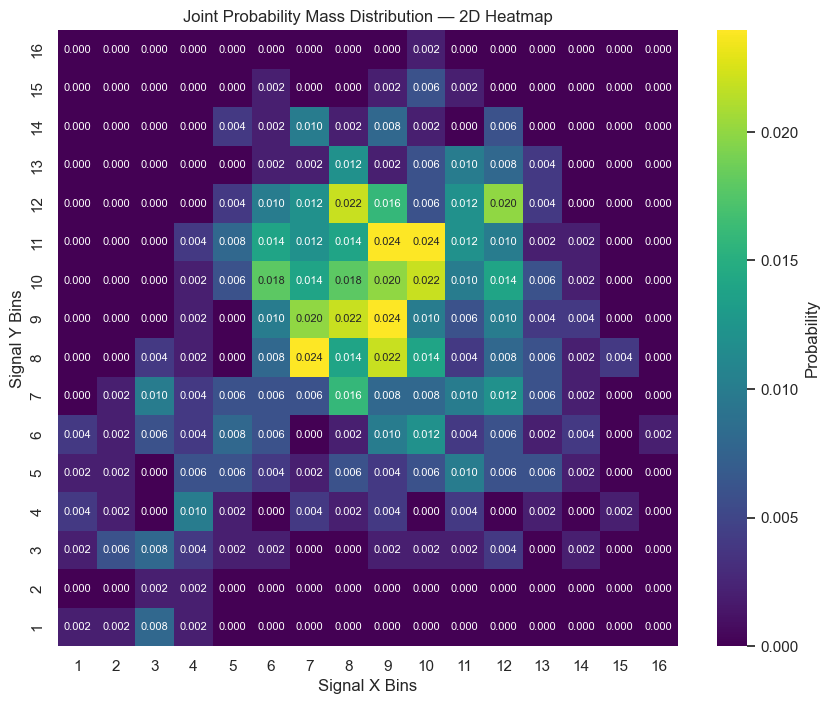

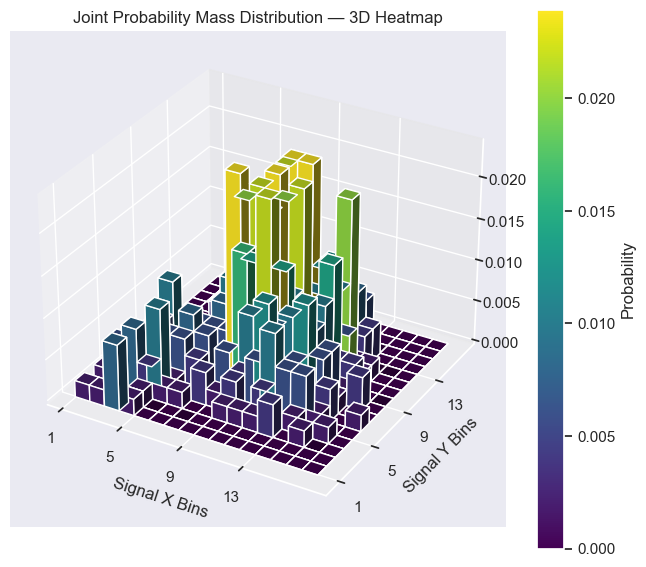

In [27]:
# 2D HEATMAP OF JOINT PROBABILITY MASS DISTRIBUTION
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(joint_probs, cmap='viridis', annot=True, fmt=".3f", cbar=True, ax=ax)
ax.invert_yaxis()

# To make the axes start with Bin 1 rather than Bin 0
new_ticks = np.arange(1, n_bin_edges + 1)
ax.set_xticks(new_ticks - 0.5)
ax.set_yticks(new_ticks - 0.5)
ax.set_xticklabels(new_ticks)
ax.set_yticklabels(new_ticks)

[ text.set_fontsize(8) for text in heatmap.texts ]
plt.xlabel('Signal X Bins')
plt.ylabel('Signal Y Bins')
heatmap.collections[0].colorbar.set_label('Probability')
plt.title('Joint Probability Mass Distribution — 2D Heatmap')
plt.show()


# 3D HEATMAP OF JOINT PROBABILITY MASS DISTRIBUTION
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
x_ticks, y_ticks = np.meshgrid(np.arange(n_bin_edges), np.arange(n_bin_edges))
cmap = plt.get_cmap('viridis')
bars = ax.bar3d(
    x_ticks.flatten(), 
    y_ticks.flatten(), 
    np.zeros_like(joint_probs).flatten(), 
    1, 1, joint_probs.flatten(), 
    shade=True,
    color=cmap(joint_probs.flatten() / joint_probs.max())
)

new_ticks = np.arange(1, n_bin_edges + 1, 4)
ax.set_xticks(new_ticks - 1.2)
ax.set_yticks(new_ticks - 0.6)
ax.set_xticklabels(new_ticks)
ax.set_yticklabels(new_ticks)

#ax.locator_params(axis='x', integer=True)
#ax.locator_params(axis='y', integer=True)
norm = plt.Normalize(vmin=joint_probs.min(), vmax=joint_probs.max())
cmap = plt.get_cmap('viridis')
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Probability')
ax.set_xlabel('Signal X Bins')
ax.set_ylabel('Signal Y Bins')
ax.set_title('Joint Probability Mass Distribution — 3D Heatmap')
plt.show()

## 3.7 Calculating Joint Entropy
We are now ready to compute the joint entropy of $X$ and $Y$. Recall that joint entropy is given by

$\begin{equation}
H(X,Y) = - \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}  p_{XY}(x,y) \log_2{p_{XY}(x,y)},
\end{equation}$

Since our ```joint_probs``` variable is already a two-dimensional matrix, we can calculate the sum of the entire matrix. Again, we add ```np.finfo(float).eps``` in case there are values of $p_{XY}(x,y)$ which are 0, leading to the indeterminate calcuation $0log_2(0)$; generally, however, it is important to take the convention $0\log_20 = 0$, as per the principle of continuity where, as $x \downarrow 0$, $x\log_2 x \rightarrow 0$.

In [28]:
S_entropy[2] = -np.sum(joint_probs * np.log2(joint_probs + np.finfo(float).eps))
print('Joint entropy \nH(X,Y) =', S_entropy[2])

Joint entropy 
H(X,Y) = 6.699166060462185


# 4. MUTUAL INFORMATION

Mutual information (MI) is a positively-biased, symmetric measure indicating how much Shannon information is shared between two discrete variables. In other words, MI can be expressed as the mutual dependence between two random variables $X$ and $Y$, or, in terms of entropy, the intersection of both Shannon entropies (See Figure X). MI is non-negative (as per Jensen's inequality) and symmetric such that $I(X;Y) = I(Y;X)$ and therefore does not describe causality or directionality. If $H(X)$ and $H(Y)$ are taken to be the marginal entropies, and &H(X,Y)& the joint entropy, MI is given by

$\begin{equation}
I(X;Y) = H(X)+H(Y)-H(X,Y)
\end{equation}$

In [29]:
MI = S_entropy[0] + S_entropy[1] - S_entropy[2]
print('Mutual Information \nI(X;Y) =',MI)

Mutual Information 
I(X;Y) = 0.4468011479585998


# 5. SYMMETRIC UNCERTAINTY

Generally, we can further compute the symmetric uncertainty between two variables 𝑋 and 𝑌 by normalising the mutual information by the entropy of the signals (i.e., between 0 and 1 where the former indicates no dependence between variables and the latter indicates complete dependence). Namely,

$
\begin{equation}
U(X;Y) = 2 \left[ \frac{I(X;Y)}{H(X)+H(Y)} \right]
\end{equation}
$

In [30]:
U = 2 * MI/(S_entropy[0] + S_entropy[1])
print('Symmetric Uncertainty \nU(X;Y) =',U)

Symmetric Uncertainty 
U(X;Y) = 0.12504987356563593
